In [1]:
%matplotlib inline
from pylab import *
import sys
from collections import namedtuple
import random
import time
import numpy as np

In [2]:
def log_normal(mu=0, sigma=1):
    return e**(mu+sigma*np.random.normal())

def exp_samples(lambd=1,n=1):
    """
    generates a numpy array of n samples distributed according to
    an exponential distribution with parameter λ
    """
    random.seed(time.time())
    return (-1/lambd)*log(rand(n))

def exp(lambd=1):
    """
    generates a sample distributed according to
    an exponential distribution with parameter λ
    """
    if lambd < 0:
        return inf()
    random.seed(time.time())
    return (-1/lambd)*log(rand())

def inf():
    return 9999

Customer = namedtuple("Customer", "service_time arrival_time patience_time")
# example: c = Customer(service_time = 1, arrival_time = 0.5, patience_time = 2)

def printarray(a):
    print(np.around(a, 3))
    
def customer(service_time=inf(), arrival_time=-1, patience_time=inf()):
    return Customer(service_time=service_time, arrival_time=arrival_time, patience_time=patience_time)

In [3]:
# Example 2: M/M/c+M not PS (normal) queue (not necessarily) starting as empty


# N0 = starting number in the queue
# Tmax = time horizon

def MM1BasicSurge(arrival_rate_func, service_rate_func, patience_rate_func,
                  number_of_servers_func, N0, Tmax):
    T             = [0]  # list of times that events occur
    t_temp        = 0    # temporary time to calculate delta
    N             = [N0]  # initial state of the system
    
    # customers currently being served by a server
    remaining_times = [customer(service_rate_func(), 0, inf())
                       for _ in range(min(number_of_servers_func(), N0))]
    
    # customers that are waiting to be served by a server
    queue = [customer(inf(), 0, patience_rate_func())
             for _ in range(N0 - number_of_servers_func())]
    
    # times spent by users inside the system
    waiting_times = []
    
    # to calculate the probability someone has to wait in the queue
    p_wait_num = 0
    p_wait_denom = 0
    
    # first event must be an arrival
    next_arrival = arrival_rate_func()
    if len(remaining_times) > 0:
        remaining_times.sort(key=lambda x: x.service_time, reverse=False)
        next_departure = remaining_times[0].service_time
    else:
        next_departure = inf()

    if len(queue) > 0:
        queue.sort(key=lambda x: x.patience_time, reverse=False)
        next_abandonment = queue[0].patience_time
    else:
        next_abandonment = inf()
    
    while T[-1] < Tmax:
        t_temp = T[-1]
        
        T.append(min(next_arrival, next_departure, next_abandonment))
            
        ##### ARRIVAL ##### 
        if T[-1] == next_arrival:
            N.append(N[-1]+1) 
            if len(remaining_times) < number_of_servers_func():
                service_time = service_rate_func(N[-1])
                remaining_times.append(customer(T[-1] + service_time, T[-1], inf()))
            else:
                patience_time = patience_rate_func()
                queue.append(customer(inf(), T[-1], T[-1] + patience_time))
                p_wait_num += 1
            p_wait_denom+=1    
            next_arrival = T[-1] + arrival_rate_func()
            #print("ARRIVAL %.3f departure %.3f abandonment %.3f" % (next_arrival, next_departure, next_abandonment))
        ##### DEPARTURE #####     
        elif T[-1] == next_departure:
            N.append(N[-1]-1)
            remaining_times.sort(key=lambda x: x.service_time, reverse=False)
            popped_customer = remaining_times.pop(0)
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)            
            if len(queue) > 0:
                queue.sort(key=lambda x: x.arrival_time, reverse=False)
                next_to_enter = queue.pop(0)
                service_time = service_rate_func(N[-1])
                remaining_times.append(customer(T[-1] + service_time, next_to_enter.arrival_time, inf()))
            #print("arrival %.3f DEPARTURE %.3f abandonment %.3f" % (next_arrival, next_departure, next_abandonment))
        ##### ABANDONMENT ##### 
        else: 
            N.append(N[-1]-1)
            queue.sort(key=lambda x: x.patience_time, reverse=False)
            popped_customer = queue.pop(0)
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)
            #print("arrival %.3f departure %.3f ABANDONMENT %.3f" % (next_arrival, next_departure, next_abandonment))
        
        if len(remaining_times) > 0:
            remaining_times.sort(key=lambda x: x.service_time, reverse=False)
            next_departure = remaining_times[0].service_time
        else:
            next_departure = inf()

        if len(queue) > 0:
            queue.sort(key=lambda x: x.patience_time, reverse=False)
            next_abandonment = queue[0].patience_time
        else:
            next_abandonment = inf()

    # discard Tmax
    T = T[:-1] 
    N = N[:-1]
    return T, N, waiting_times, (p_wait_num)/(p_wait_denom)

Model 2. The surge policy doubles the service rate when queue length >= 1. 
Mean wait time over 100 runs 0.963827
p 0.046667


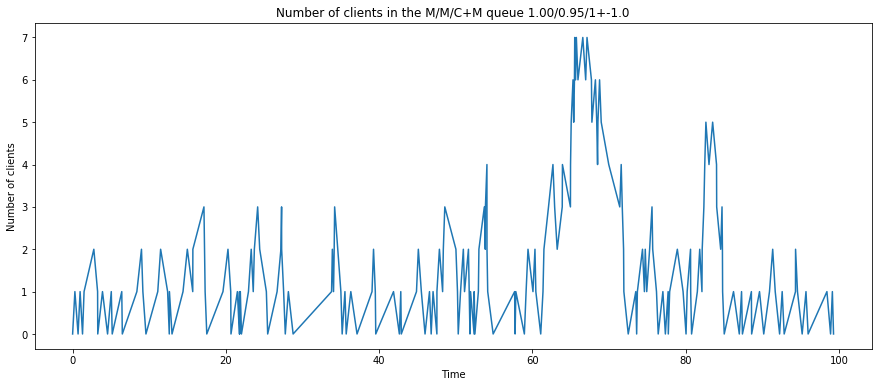

In [16]:
# lambda = arrival rate, exponentially distributed
# mu = service rate, exponentially distributed
# gamma = patience rate, exponentially distributed
# c = number of servers

lambd = .999
mu1 = .95
mu2 = 2
gamma = -1
c = 1
N0 = 0
Tmax = 100
surge_threshold = 1

def arrival_rate_func():
    return exp(lambd)

def service_rate_func(queue_length):
    if queue_length >= surge_threshold:
        return exp(mu2)
    return exp(mu1)

def patience_rate_func():
    return exp(gamma)

def number_of_servers_func():
    return c

T, N, W, p_wait = MM1BasicSurge(arrival_rate_func, service_rate_func, patience_rate_func,
                                number_of_servers_func, N0, Tmax)
figure(figsize=(15,6))
plot(T, N)
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C+M queue %.2f/%.2f/%d+%.1f' % (lambd, mu1, c, gamma))
print("Model 2. The surge policy doubles the service rate when queue length >= 1. " + 
      "")


wait_times = list()
for _ in range(100):
    _, _, W, _ = MM1BasicSurge(arrival_rate_func, service_rate_func, patience_rate_func,
                                number_of_servers_func, N0, Tmax)
    wait_times.append(mean(W))
print("Mean wait time over 100 runs %f" % (mean(wait_times)))
print("p %f" % ((lambd - mu1)/(mu2-mu1)))

Model 2. The surge policy doubles the service rate when queue length >= 2. 
Mean wait time over 100 runs 2.072908
p 0.046667


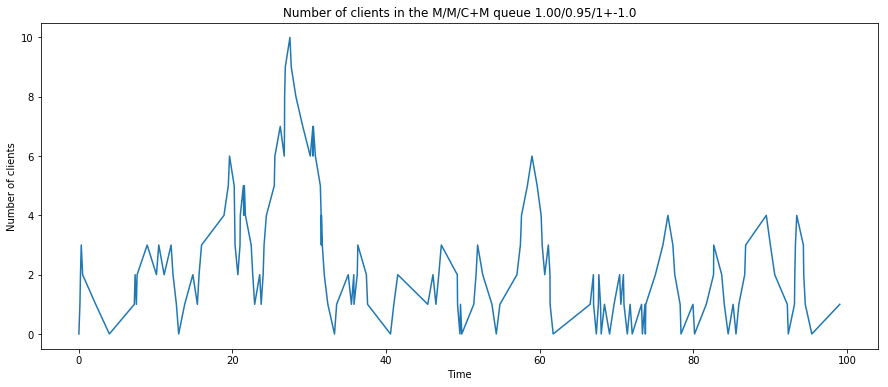

In [17]:
# lambda = arrival rate, exponentially distributed
# mu = service rate, exponentially distributed
# gamma = patience rate, exponentially distributed
# c = number of servers

lambd = .999
mu1 = .95
mu2 = 2
gamma = -1
c = 1
N0 = 0
Tmax = 100
surge_threshold = 2

def arrival_rate_func():
    return exp(lambd)

def service_rate_func(queue_length):
    if queue_length >= surge_threshold:
        return exp(mu2)
    return exp(mu1)

def patience_rate_func():
    return exp(gamma)

def number_of_servers_func():
    return c

T, N, W, p_wait = MM1BasicSurge(arrival_rate_func, service_rate_func, patience_rate_func,
                                number_of_servers_func, N0, Tmax)
figure(figsize=(15,6))
plot(T, N)
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C+M queue %.2f/%.2f/%d+%.1f' % (lambd, mu1, c, gamma))
print("Model 2. The surge policy doubles the service rate when queue length >= 2. " + 
      "")


wait_times = list()
for _ in range(100):
    _, _, W, _ = MM1BasicSurge(arrival_rate_func, service_rate_func, patience_rate_func,
                                number_of_servers_func, N0, Tmax)
    wait_times.append(mean(W))
print("Mean wait time over 100 runs %f" % (mean(wait_times)))
print("p %f" % ((lambd - mu1)/(mu2-mu1)))

Model 2. The surge policy doubles the service rate when queue length >= 3. 
Mean wait time over 100 runs 2.412180
p 0.046667


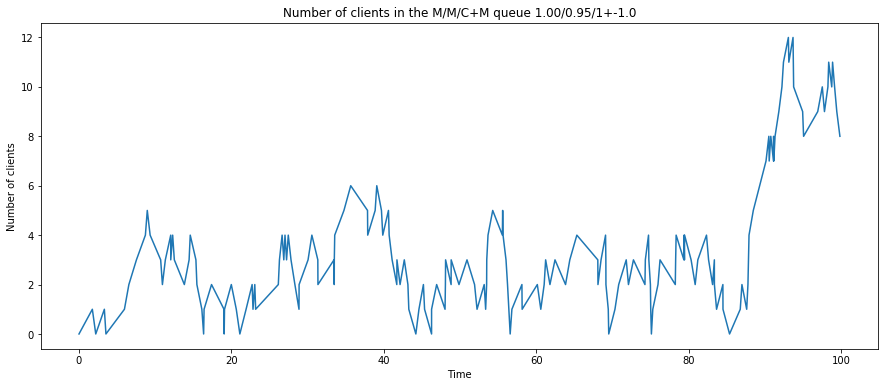

In [18]:
# lambda = arrival rate, exponentially distributed
# mu = service rate, exponentially distributed
# gamma = patience rate, exponentially distributed
# c = number of servers

lambd = .999
mu1 = .95
mu2 = 2
gamma = -1
c = 1
N0 = 0
Tmax = 100
surge_threshold = 3

def arrival_rate_func():
    return exp(lambd)

def service_rate_func(queue_length):
    if queue_length >= surge_threshold:
        return exp(mu2)
    return exp(mu1)

def patience_rate_func():
    return exp(gamma)

def number_of_servers_func():
    return c

T, N, W, p_wait = MM1BasicSurge(arrival_rate_func, service_rate_func, patience_rate_func,
                                number_of_servers_func, N0, Tmax)
figure(figsize=(15,6))
plot(T, N)
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C+M queue %.2f/%.2f/%d+%.1f' % (lambd, mu1, c, gamma))
print("Model 2. The surge policy doubles the service rate when queue length >= 3. " + 
      "")


wait_times = list()
for _ in range(100):
    _, _, W, _ = MM1BasicSurge(arrival_rate_func, service_rate_func, patience_rate_func,
                                number_of_servers_func, N0, Tmax)
    wait_times.append(mean(W))
print("Mean wait time over 100 runs %f" % (mean(wait_times)))
print("p %f" % ((lambd - mu1)/(mu2-mu1)))

Model 2. The surge policy doubles the service rate when queue length >= 4. 
Mean wait time over 100 runs 2.857029
p 0.046667


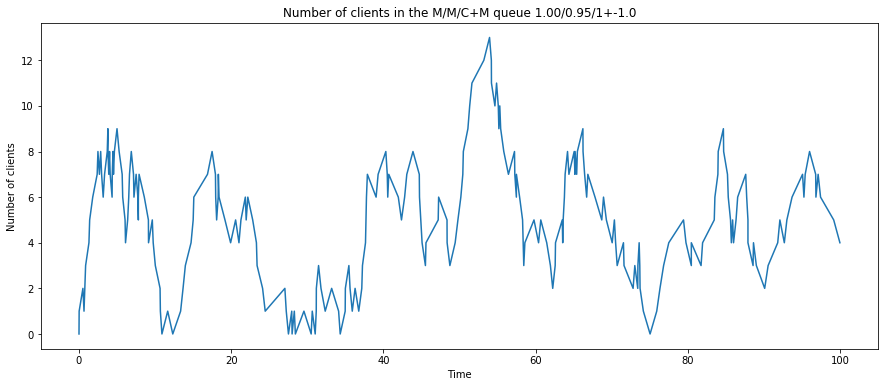

In [19]:
# lambda = arrival rate, exponentially distributed
# mu = service rate, exponentially distributed
# gamma = patience rate, exponentially distributed
# c = number of servers

lambd = .999
mu1 = .95
mu2 = 2
gamma = -1
c = 1
N0 = 0
Tmax = 100
surge_threshold = 4

def arrival_rate_func():
    return exp(lambd)

def service_rate_func(queue_length):
    if queue_length >= surge_threshold:
        return exp(mu2)
    return exp(mu1)

def patience_rate_func():
    return exp(gamma)

def number_of_servers_func():
    return c

T, N, W, p_wait = MM1BasicSurge(arrival_rate_func, service_rate_func, patience_rate_func,
                                number_of_servers_func, N0, Tmax)
figure(figsize=(15,6))
plot(T, N)
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C+M queue %.2f/%.2f/%d+%.1f' % (lambd, mu1, c, gamma))
print("Model 2. The surge policy doubles the service rate when queue length >= 4. " + 
      "")


wait_times = list()
for _ in range(100):
    _, _, W, _ = MM1BasicSurge(arrival_rate_func, service_rate_func, patience_rate_func,
                                number_of_servers_func, N0, Tmax)
    wait_times.append(mean(W))
print("Mean wait time over 100 runs %f" % (mean(wait_times)))
print("p %f" % ((lambd - mu1)/(mu2-mu1)))

Model 2. The surge policy doubles the service rate when queue length >= 5. 
Mean wait time over 100 runs 3.257445
p 0.046667


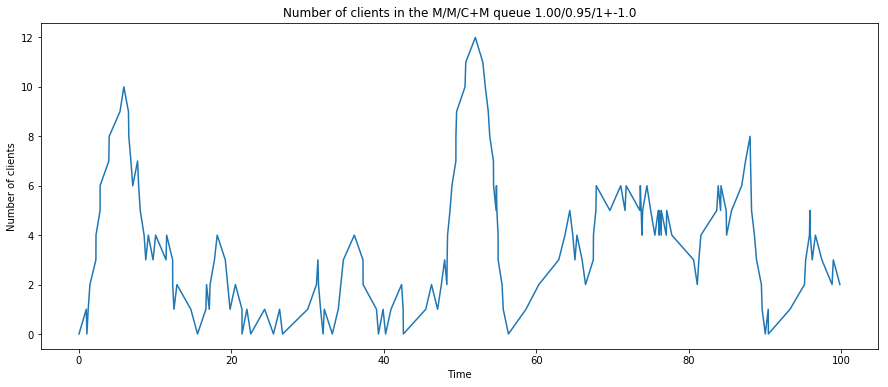

In [20]:
# lambda = arrival rate, exponentially distributed
# mu = service rate, exponentially distributed
# gamma = patience rate, exponentially distributed
# c = number of servers

lambd = .999
mu1 = .95
mu2 = 2
gamma = -1
c = 1
N0 = 0
Tmax = 100
surge_threshold = 5

def arrival_rate_func():
    return exp(lambd)

def service_rate_func(queue_length):
    if queue_length >= surge_threshold:
        return exp(mu2)
    return exp(mu1)

def patience_rate_func():
    return exp(gamma)

def number_of_servers_func():
    return c

T, N, W, p_wait = MM1BasicSurge(arrival_rate_func, service_rate_func, patience_rate_func,
                                number_of_servers_func, N0, Tmax)
figure(figsize=(15,6))
plot(T, N)
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C+M queue %.2f/%.2f/%d+%.1f' % (lambd, mu1, c, gamma))
print("Model 2. The surge policy doubles the service rate when queue length >= 5. " + 
      "")


wait_times = list()
for _ in range(100):
    _, _, W, _ = MM1BasicSurge(arrival_rate_func, service_rate_func, patience_rate_func,
                                number_of_servers_func, N0, Tmax)
    wait_times.append(mean(W))
print("Mean wait time over 100 runs %f" % (mean(wait_times)))
print("p %f" % ((lambd - mu1)/(mu2-mu1)))

Model 2. The surge policy doubles the service rate when queue length >= 10. 
Mean wait time over 100 runs 5.615751
p 0.046667


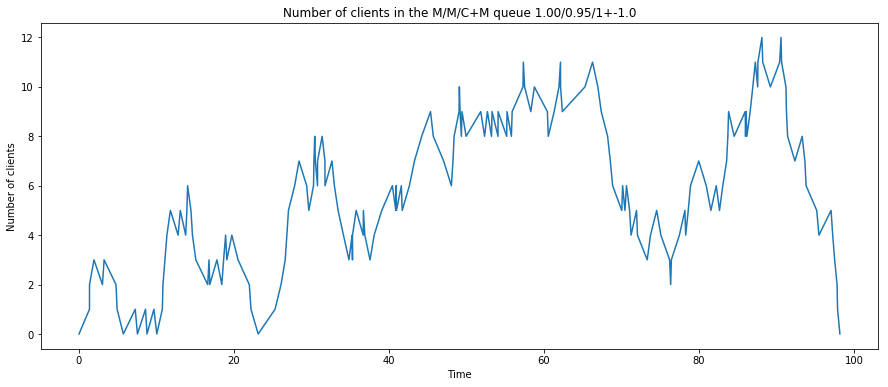

In [21]:
# lambda = arrival rate, exponentially distributed
# mu = service rate, exponentially distributed
# gamma = patience rate, exponentially distributed
# c = number of servers

lambd = .999
mu1 = .95
mu2 = 2
gamma = -1
c = 1
N0 = 0
Tmax = 100
surge_threshold = 10

def arrival_rate_func():
    return exp(lambd)

def service_rate_func(queue_length):
    if queue_length >= surge_threshold:
        return exp(mu2)
    return exp(mu1)

def patience_rate_func():
    return exp(gamma)

def number_of_servers_func():
    return c

T, N, W, p_wait = MM1BasicSurge(arrival_rate_func, service_rate_func, patience_rate_func,
                                number_of_servers_func, N0, Tmax)
figure(figsize=(15,6))
plot(T, N)
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C+M queue %.2f/%.2f/%d+%.1f' % (lambd, mu1, c, gamma))
print("Model 2. The surge policy doubles the service rate when queue length >= 10. " + 
      "")


wait_times = list()
for _ in range(100):
    _, _, W, _ = MM1BasicSurge(arrival_rate_func, service_rate_func, patience_rate_func,
                                number_of_servers_func, N0, Tmax)
    wait_times.append(mean(W))
print("Mean wait time over 100 runs %f" % (mean(wait_times)))
print("p %f" % ((lambd - mu1)/(mu2-mu1)))

Model 2. The surge policy doubles the service rate when queue length >= 20. 
Mean wait time over 100 runs 7.724920
p 0.046667


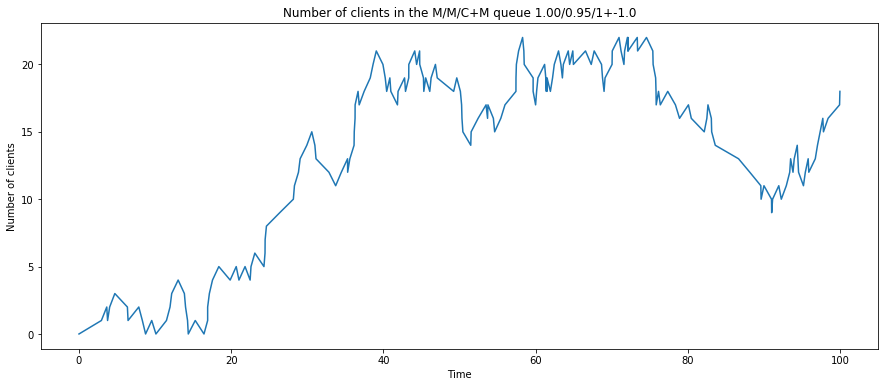

In [25]:
# lambda = arrival rate, exponentially distributed
# mu = service rate, exponentially distributed
# gamma = patience rate, exponentially distributed
# c = number of servers

lambd = .999
mu1 = .95
mu2 = 2
gamma = -1
c = 1
N0 = 0
Tmax = 100
surge_threshold = 20

def arrival_rate_func():
    return exp(lambd)

def service_rate_func(queue_length):
    if queue_length >= surge_threshold:
        return exp(mu2)
    return exp(mu1)

def patience_rate_func():
    return exp(gamma)

def number_of_servers_func():
    return c

T, N, W, p_wait = MM1BasicSurge(arrival_rate_func, service_rate_func, patience_rate_func,
                                number_of_servers_func, N0, Tmax)
figure(figsize=(15,6))
plot(T, N)
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C+M queue %.2f/%.2f/%d+%.1f' % (lambd, mu1, c, gamma))
print("Model 2. The surge policy doubles the service rate when queue length >= 20. " + 
      "")


wait_times = list()
for _ in range(100):
    _, _, W, _ = MM1BasicSurge(arrival_rate_func, service_rate_func, patience_rate_func,
                                number_of_servers_func, N0, Tmax)
    wait_times.append(mean(W))
print("Mean wait time over 100 runs %f" % (mean(wait_times)))
print("p %f" % ((lambd - mu1)/(mu2-mu1)))